# Simple Bond Analysis for Dopant Clustering

This notebook analyzes how bonds between atoms persist over time in molecular dynamics simulations.

## What we're doing:
1. Load trajectory files (movies of atoms moving over time)
2. Find which atoms are bonded to each other in each frame
3. Track which bonds survive from start to finish
4. Count how many bonds break vs stay stable

## Why this matters:
- Stable bonds = atoms that like to cluster together
- Breaking bonds = atoms that don't cluster well
- This helps us understand which dopant elements form stable clusters in MoS2

## Step 1: Import Libraries

We need these tools:
- `os`: to find files on the computer
- `ase`: to read atom structures and calculate distances
- `datetime`: to timestamp our results

In [22]:
import os
from datetime import datetime
from ase.io import read
from ase.neighborlist import NeighborList, natural_cutoffs

print("✅ Libraries loaded successfully")
print(f"⏰ Starting analysis at: {datetime.now()}")

✅ Libraries loaded successfully
⏰ Starting analysis at: 2025-09-19 12:18:39.092516


## Step 2: Configuration

Set up the basic parameters for our analysis:
- `BASE_DIR`: Where to find the trajectory files
- `CUTOFF_FACTOR`: How close atoms need to be to count as "bonded" (1.2 = 1.2x the natural bond distance)
- `DOPANTS`: List of all dopant elements we want to analyze

The code will loop through each dopant and analyze them one by one.

In [23]:
# Configuration - CHANGE THESE VALUES AS NEEDED
BASE_DIR = "/home/afaiyad/borgstore/MoS2_Omat/05_Equlibriation/equilibriated_structures_doped"
Frames = 1000
CUTOFF_FACTOR = 1.2  # How close = bonded (1.2 = 1.2x normal bond distance)

# List of all dopants to analyze
DOPANTS = [
    "Ir", "Re", "Rh", "Si", "Au", "Ru", "Al", "Pd", "Ti", "Ta", "Li", "Zn", "Nb", "Cu", "Ag", "Na", "C", "Pt", "V", "Cl", "O", "Fe", "N", "Te", "F"
] #"Ir", "Re", "Rh", "Si", "Au", "Ru", "Al", "Pd", "Ti", "Ta", "Li", "Zn", "Nb", "Cu", "Ag", "Na", "C", "Pt", "V", "Cl", "O", "Fe", "N", "Te", "F"

print(f"📁 Looking for files in: {BASE_DIR}")
print(f"🔍 Analyzing {len(DOPANTS)} dopant elements")
print(f"📏 Bond cutoff factor: {CUTOFF_FACTOR}")
print(f"🧪 Dopants: {', '.join(DOPANTS)}")

📁 Looking for files in: /home/afaiyad/borgstore/MoS2_Omat/05_Equlibriation/equilibriated_structures_doped
🔍 Analyzing 25 dopant elements
📏 Bond cutoff factor: 1.2
🧪 Dopants: Ir, Re, Rh, Si, Au, Ru, Al, Pd, Ti, Ta, Li, Zn, Nb, Cu, Ag, Na, C, Pt, V, Cl, O, Fe, N, Te, F


## Step 3: Find All Trajectory Files

Look for trajectory files for each dopant in our list.
Each file should be named like: `nvt_equilibration_MoS2_8x8x4_5wt_{DOPANT}.traj`

We'll create a dictionary to store which files we found for each dopant.

In [24]:
# Find ML-optimized structure files for all dopants
# Only Mo and S substitutions (excluding intercalated/interstitial cases)
from ase.io import read

ML_STRUCTURES_DIR = "/home/afaiyad/borgstore/MoS2_Omat/02_Melting_quenching/T_18_All_dopant_calculation/ml_optimized_structures"

dopant_structures = {}

print("🔍 Searching for ML-optimized structure files...")
print("📝 Note: Excluding intercalated (interstitial) cases")
print("="*60)

for dopant in DOPANTS:
    # Define only the 2 substitution file patterns (excluding interstitial)
    file_patterns = {
        'Mo_substitution': f"MoS2_49Mo1{dopant}_ml_opt.xyz",
        'S_substitution': f"MoS2_49S1{dopant}_ml_opt.xyz"
    }
    
    dopant_structures[dopant] = {}
    found_files = 0
    
    for structure_type, filename in file_patterns.items():
        full_path = os.path.join(ML_STRUCTURES_DIR, filename)
        
        if os.path.exists(full_path):
            try:
                # Read the structure using ASE
                structure = read(full_path)
                dopant_structures[dopant][structure_type] = {
                    'path': full_path,
                    'structure': structure,
                    'filename': filename
                }
                found_files += 1
                print(f"✅ {dopant} ({structure_type}): Found {filename}")
            except Exception as e:
                print(f"❌ {dopant} ({structure_type}): Error reading {filename} - {str(e)}")
        else:
            print(f"❌ {dopant} ({structure_type}): File not found - {filename}")
    
    # Summary for this dopant
    if found_files == 2:
        print(f"🎯 {dopant}: Both substitution structures found!")
    elif found_files > 0:
        print(f"⚠️  {dopant}: Only {found_files}/2 structures found")
    else:
        print(f"💥 {dopant}: No structures found")
        # Remove empty entry
        del dopant_structures[dopant]
    
    print("-" * 40)

print("="*60)
print(f"📊 SUMMARY OF ML-OPTIMIZED STRUCTURES (SUBSTITUTIONS ONLY)")
print("="*60)

complete_dopants = []
partial_dopants = []
missing_dopants = []

for dopant in DOPANTS:
    if dopant in dopant_structures:
        structure_count = len(dopant_structures[dopant])
        if structure_count == 2:
            complete_dopants.append(dopant)
        else:
            partial_dopants.append(f"{dopant}({structure_count}/2)")
    else:
        missing_dopants.append(dopant)

print(f"✅ Complete sets (2/2): {len(complete_dopants)} dopants")
if complete_dopants:
    print(f"   {', '.join(complete_dopants)}")

print(f"⚠️  Partial sets: {len(partial_dopants)} dopants")
if partial_dopants:
    print(f"   {', '.join(partial_dopants)}")

print(f"❌ Missing all files: {len(missing_dopants)} dopants")
if missing_dopants:
    print(f"   {', '.join(missing_dopants)}")

# Show detailed statistics
total_structures = sum(len(structures) for structures in dopant_structures.values())
total_possible = len(DOPANTS) * 2  # Only 2 types now

print(f"\n📈 Structure Loading Statistics:")
print(f"   • Total structures loaded: {total_structures}/{total_possible}")
print(f"   • Success rate: {(total_structures/total_possible)*100:.1f}%")
print(f"   • Dopants with data: {len(dopant_structures)}/{len(DOPANTS)}")

# Show structure types breakdown
if dopant_structures:
    structure_type_counts = {'Mo_substitution': 0, 'S_substitution': 0}
    for dopant_data in dopant_structures.values():
        for structure_type in dopant_data.keys():
            structure_type_counts[structure_type] += 1
    
    print(f"\n🏗️  Structure Types Found:")
    for struct_type, count in structure_type_counts.items():
        print(f"   • {struct_type}: {count} files")

print(f"\n🔬 Ready for analysis: {', '.join(sorted(dopant_structures.keys()))}")

🔍 Searching for ML-optimized structure files...
📝 Note: Excluding intercalated (interstitial) cases
✅ Ir (Mo_substitution): Found MoS2_49Mo1Ir_ml_opt.xyz
✅ Ir (S_substitution): Found MoS2_49S1Ir_ml_opt.xyz
🎯 Ir: Both substitution structures found!
----------------------------------------
✅ Re (Mo_substitution): Found MoS2_49Mo1Re_ml_opt.xyz
✅ Re (S_substitution): Found MoS2_49S1Re_ml_opt.xyz
🎯 Re: Both substitution structures found!
----------------------------------------
✅ Rh (Mo_substitution): Found MoS2_49Mo1Rh_ml_opt.xyz
✅ Rh (S_substitution): Found MoS2_49S1Rh_ml_opt.xyz
🎯 Rh: Both substitution structures found!
----------------------------------------
✅ Si (Mo_substitution): Found MoS2_49Mo1Si_ml_opt.xyz
✅ Si (S_substitution): Found MoS2_49S1Si_ml_opt.xyz
🎯 Si: Both substitution structures found!
----------------------------------------
✅ Au (Mo_substitution): Found MoS2_49Mo1Au_ml_opt.xyz
✅ Au (S_substitution): Found MoS2_49S1Au_ml_opt.xyz
🎯 Au: Both substitution structures fou

## Step 4: Load All Trajectories (Parallel Processing)

Read trajectory files for all available dopants using parallel processing.
This uses all CPU cores to load multiple files simultaneously, making it much faster!

We'll store the frames for each dopant in a dictionary for later analysis.

In [25]:
import multiprocessing as mp
from functools import partial
import numpy as np

def analyze_single_dopant_structure(dopant_info):
    """
    Analyze ML-optimized structures for a single dopant.
    Calculates properties for Mo substitution and S substitution configurations.
    
    Input: dopant_info = (dopant_name, structure_dict)
    Output: (dopant_name, analysis_dict) or (dopant_name, error_message)
    """
    dopant, structure_data = dopant_info
    
    try:
        analysis_results = {}
        
        for structure_type, struct_info in structure_data.items():
            atoms = struct_info['structure']
            
            # Basic structure analysis
            structure_analysis = {
                'filename': struct_info['filename'],
                'path': struct_info['path'],
                'total_atoms': len(atoms),
                'cell_volume': atoms.get_volume(),
                'energy': atoms.get_potential_energy() if atoms.get_potential_energy() is not None else None,
                'forces': atoms.get_forces() if len(atoms.get_forces()) > 0 else None
            }
            
            # Count atoms by type
            symbols = atoms.get_chemical_symbols()
            atom_counts = {}
            for symbol in set(symbols):
                atom_counts[symbol] = symbols.count(symbol)
            structure_analysis['atom_counts'] = atom_counts
            
            # Find dopant atoms
            dopant_indices = [i for i, symbol in enumerate(symbols) if symbol == dopant]
            structure_analysis['dopant_count'] = len(dopant_indices)
            structure_analysis['dopant_indices'] = dopant_indices
            
            # Calculate dopant positions
            if dopant_indices:
                dopant_positions = atoms.positions[dopant_indices]
                structure_analysis['dopant_positions'] = dopant_positions
                
                # If multiple dopant atoms, calculate distances between them
                if len(dopant_indices) > 1:
                    from scipy.spatial.distance import pdist
                    distances = pdist(dopant_positions)
                    structure_analysis['dopant_distances'] = distances
                    structure_analysis['min_dopant_distance'] = np.min(distances)
                    structure_analysis['max_dopant_distance'] = np.max(distances)
                    structure_analysis['avg_dopant_distance'] = np.mean(distances)
            
            # Calculate lattice parameters
            cell = atoms.get_cell()
            structure_analysis['lattice_vectors'] = cell
            structure_analysis['lattice_lengths'] = np.linalg.norm(cell, axis=1)
            
            # Store the analysis
            analysis_results[structure_type] = structure_analysis
        
        return (dopant, analysis_results)
        
    except Exception as e:
        return (dopant, f"ERROR: {str(e)}")

def load_ml_structures_parallel():
    """
    Load and analyze all ML-optimized structures using parallel processing.
    """
    
    # Check if dopant_structures is available from previous step
    if 'dopant_structures' not in globals():
        print("❌ ERROR: dopant_structures not found!")
        print("🔄 Please run Step 3 first to load ML-optimized structures")
        return {}
    
    print("📖 Analyzing ML-optimized structures using parallel processing...")
    print(f"🖥️  Using {mp.cpu_count()} CPU cores")
    print("="*70)
    
    # Prepare data for parallel processing
    dopant_data_list = list(dopant_structures.items())
    
    print(f"🚀 Starting parallel analysis of {len(dopant_data_list)} dopants...")
    print(f"📊 Total structure files to analyze: {sum(len(struct_data) for _, struct_data in dopant_data_list)}")
    
    # Use multiprocessing to analyze structures in parallel
    analyzed_structures = {}
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        # Map the analysis function to all dopant structures
        results = pool.map(analyze_single_dopant_structure, dopant_data_list)
    
    # Process the results
    successful_analyses = 0
    failed_analyses = 0
    
    print("\n📋 Processing analysis results...")
    
    for dopant, result in results:
        if isinstance(result, dict):
            # Success
            analyzed_structures[dopant] = result
            successful_analyses += 1
            
            # Show summary for this dopant
            structure_types = list(result.keys())
            total_atoms = sum(result[st]['total_atoms'] for st in structure_types)
            dopant_counts = [result[st]['dopant_count'] for st in structure_types]
            
            print(f"✅ {dopant}: {len(structure_types)} structures, {total_atoms} total atoms, dopant counts: {dopant_counts}")
        else:
            # Error
            failed_analyses += 1
            print(f"❌ {dopant}: {result}")
    
    print("="*70)
    print(f"🎯 PARALLEL STRUCTURE ANALYSIS SUMMARY")
    print("="*70)
    print(f"✅ Successfully analyzed: {successful_analyses}/{len(dopant_data_list)} dopants")
    print(f"❌ Failed to analyze: {failed_analyses} dopants")
    
    if analyzed_structures:
        # Calculate comprehensive statistics
        total_structures = sum(len(data) for data in analyzed_structures.values())
        all_structure_types = set()
        energy_available = 0
        forces_available = 0
        
        print(f"📊 Ready to analyze: {', '.join(sorted(analyzed_structures.keys()))}")
        
        # Detailed statistics
        for dopant_data in analyzed_structures.values():
            for structure_type, analysis in dopant_data.items():
                all_structure_types.add(structure_type)
                if analysis.get('energy') is not None:
                    energy_available += 1
                if analysis.get('forces') is not None:
                    forces_available += 1
        
        print(f"\n📈 Detailed Statistics:")
        print(f"   • Total structures analyzed: {total_structures}")
        print(f"   • Structure types found: {', '.join(sorted(all_structure_types))}")
        print(f"   • Structures with energy data: {energy_available}/{total_structures}")
        print(f"   • Structures with force data: {forces_available}/{total_structures}")
        
        # Show examples of atom counts
        print(f"\n🧪 Sample Composition Analysis:")
        sample_dopants = list(analyzed_structures.keys())[:3]
        for dopant in sample_dopants:
            print(f"   {dopant}:")
            for structure_type, analysis in analyzed_structures[dopant].items():
                atom_counts = analysis['atom_counts']
                composition = ', '.join([f"{symbol}:{count}" for symbol, count in atom_counts.items()])
                print(f"     • {structure_type}: {composition}")
        
        if len(sample_dopants) < len(analyzed_structures):
            remaining = len(analyzed_structures) - len(sample_dopants)
            print(f"     ... and {remaining} more dopants")
    
    return analyzed_structures

# Execute the parallel loading and analysis
ml_structure_analysis = load_ml_structures_parallel()

print(f"\n🔬 Analysis complete! Data stored in 'ml_structure_analysis' variable")
print(f"🗂️  Access pattern: ml_structure_analysis['dopant']['structure_type']['property']")
print(f"📝 Example: ml_structure_analysis['Ag']['Mo_substitution']['total_atoms']")

📖 Analyzing ML-optimized structures using parallel processing...
🖥️  Using 28 CPU cores
🚀 Starting parallel analysis of 25 dopants...
📊 Total structure files to analyze: 50

📋 Processing analysis results...
✅ Ir: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Re: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Rh: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Si: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Au: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Ru: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Al: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Pd: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Ti: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Ta: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Li: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Zn: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Nb: 2 structures, 96 total atoms, dopant counts: [1, 1]
✅ Cu: 2 structures, 96 total atoms, dop

In [26]:
##Distance_calculator_block_ml
# Modified Mo-Dopant Distance Analysis (without Interstitial cases)
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def calculate_bond_distance(atoms, dopant, config_type):
    """Calculate appropriate bond distance based on configuration type."""
    symbols = atoms.get_chemical_symbols()
    positions = atoms.get_positions()
    
    if config_type == 'Mo_substitution':
        # For Mo substitution: calculate S-dopant distance
        ref_indices = [i for i, symbol in enumerate(symbols) if symbol == 'S']
        ref_element = 'S'
    else:
        # For S substitution: calculate Mo-dopant distance
        ref_indices = [i for i, symbol in enumerate(symbols) if symbol == 'Mo']
        ref_element = 'Mo'
    
    dopant_indices = [i for i, symbol in enumerate(symbols) if symbol == dopant]
    
    if len(ref_indices) == 0 or len(dopant_indices) == 0:
        return None, ref_element
    
    ref_positions = positions[ref_indices]
    dopant_positions = positions[dopant_indices]
    
    # Calculate all reference-dopant distances
    diff = ref_positions[:, np.newaxis, :] - dopant_positions[np.newaxis, :, :]
    all_distances = np.linalg.norm(diff, axis=2)
    return np.min(all_distances), ref_element

# Check if required data exists
if 'ml_structure_analysis' not in globals():
    print("❌ ERROR: ml_structure_analysis not found! Run Step 4 first.")
else:
    print("⚡ Extracting bond distances (S-dopant for Mo_sub, Mo-dopant for S_sub)...")
    
    # Initialize the data collection
    csv_data = []
    
    # Process each dopant
    for dopant in sorted(dopant_structures.keys()):
        print(f"📊 Processing {dopant}...")
        row = {'dopant_name': dopant}
        structure_dict = dopant_structures[dopant]
        
        # Extract distances for each configuration (only S and Mo substitution)
        for config_type in ['S_substitution', 'Mo_substitution']:
            if config_type in structure_dict:
                # Get the atoms object from dopant_structures
                atoms = dopant_structures[dopant][config_type]['structure']
                distance, ref_element = calculate_bond_distance(atoms, dopant, config_type)
                
                # Map to CSV column names
                if config_type == 'S_substitution':
                    row['S_sub'] = round(distance, 3) if distance else None
                    print(f"   S_substitution: {ref_element}-{dopant} = {distance:.3f} Å" if distance else f"   S_substitution: No distance calculated")
                elif config_type == 'Mo_substitution':
                    row['Mo_sub'] = round(distance, 3) if distance else None
                    print(f"   Mo_substitution: {ref_element}-{dopant} = {distance:.3f} Å" if distance else f"   Mo_substitution: No distance calculated")
            else:
                # Handle missing configurations
                if config_type == 'S_substitution':
                    row['S_sub'] = None
                    print(f"   S_substitution: Configuration not found")
                elif config_type == 'Mo_substitution':
                    row['Mo_sub'] = None
                    print(f"   Mo_substitution: Configuration not found")
        
        csv_data.append(row)
    
    # Create DataFrame and display
    df = pd.DataFrame(csv_data)
    df = df.sort_values('dopant_name')
    
    print("\n📊 Bond Distances (Å):")
    print("   S_sub: Mo-Dopant distances")
    print("   Mo_sub: S-Dopant distances") 
    print("="*60)
    print(df.to_string(index=False))
    
    # Save to CSV
    csv_filename = 'mo_dopant_distances.csv'
    df.to_csv(csv_filename, index=False)
    print(f"\n💾 Data saved to: {csv_filename}")
    
    # Store DataFrame for further use
    mo_dopant_distances_df = df
    print("✅ Data available in variable: mo_dopant_distances_df")


⚡ Extracting bond distances (S-dopant for Mo_sub, Mo-dopant for S_sub)...
📊 Processing Ag...
   S_substitution: Mo-Ag = 2.895 Å
   Mo_substitution: S-Ag = 2.541 Å
📊 Processing Al...
   S_substitution: Mo-Al = 2.783 Å
   Mo_substitution: S-Al = 2.429 Å
📊 Processing Au...
   S_substitution: Mo-Au = 2.784 Å
   Mo_substitution: S-Au = 2.400 Å
📊 Processing C...
   S_substitution: Mo-C = 2.009 Å
   Mo_substitution: S-C = 1.768 Å
📊 Processing Cl...
   S_substitution: Mo-Cl = 2.495 Å
   Mo_substitution: S-Cl = 2.832 Å
📊 Processing Cu...
   S_substitution: Mo-Cu = 2.660 Å
   Mo_substitution: S-Cu = 2.290 Å
📊 Processing F...
   S_substitution: Mo-F = 2.242 Å
   Mo_substitution: S-F = 2.787 Å
📊 Processing Fe...
   S_substitution: Mo-Fe = 2.583 Å
   Mo_substitution: S-Fe = 2.310 Å
📊 Processing Ir...
   S_substitution: Mo-Ir = 2.526 Å
   Mo_substitution: S-Ir = 2.370 Å
📊 Processing Li...
   S_substitution: Mo-Li = 3.034 Å
   Mo_substitution: S-Li = 2.487 Å
📊 Processing N...
   S_substitution: Mo-N 

In [27]:
# Check for DFT Results from Quantum Espresso
import os
import pandas as pd

def check_dft_trajectories():
    """
    Check for DFT results in the 00_formation_energy_structures_missing_structures folder.
    Look for espresso.pwo files in the subfolders for each dopant configuration.
    Only checks S_substitution and Mo_substitution cases.
    """
    
    DFT_BASE_DIR = "/home/afaiyad/borgstore/MoS2_Omat/02_Melting_quenching/T_18_All_dopant_calculation/01_formation_energy_structures_6x6x4_"
    
    print("🔍 Searching for DFT results (Quantum Espresso)...")
    print(f"📁 Base directory: {DFT_BASE_DIR}")
    print("="*80)
    
    if not os.path.exists(DFT_BASE_DIR):
        print(f"❌ ERROR: DFT directory not found: {DFT_BASE_DIR}")
        return {}
    
    # Get all available dopants from the existing ML analysis
    if 'dopant_structures' not in globals():
        print("❌ ERROR: dopant_structures not found! Run Step 3 first.")
        return {}
    
    available_dopants = sorted(dopant_structures.keys())
    print(f"🧪 Checking DFT results for {len(available_dopants)} dopants:")
    print(f"   {', '.join(available_dopants)}")
    print()
    
    dft_results = {}
    
    for dopant in available_dopants:
        print(f"🔬 Checking {dopant}...")
        
        # Define expected folder patterns for each configuration (only S and Mo substitution)
        folder_patterns = {
            'Mo_substitution': f"QE_MoS2_49Mo1{dopant}",
            'S_substitution': f"QE_MoS2_49S1{dopant}"
        }
        
        dopant_dft_data = {}
        found_configs = 0
        
        for config_type, folder_name in folder_patterns.items():
            folder_path = os.path.join(DFT_BASE_DIR, folder_name)
            espresso_file = os.path.join(folder_path, "espresso.pwo")
            
            # Check if folder and espresso.pwo file exist
            if os.path.exists(folder_path):
                if os.path.exists(espresso_file):
                    # Check file size to ensure it's not empty
                    file_size = os.path.getsize(espresso_file)
                    if file_size > 1000:  # At least 1KB suggests real content
                        dopant_dft_data[config_type] = {
                            'folder_path': folder_path,
                            'espresso_file': espresso_file,
                            'file_size_kb': round(file_size / 1024, 1),
                            'status': 'FOUND'
                        }
                        found_configs += 1
                        print(f"   ✅ {config_type}: {folder_name} ({file_size/1024:.1f} KB)")
                    else:
                        dopant_dft_data[config_type] = {
                            'folder_path': folder_path,
                            'espresso_file': espresso_file,
                            'file_size_kb': round(file_size / 1024, 1),
                            'status': 'EMPTY'
                        }
                        print(f"   ⚠️  {config_type}: {folder_name} (file too small: {file_size} bytes)")
                else:
                    print(f"   ❌ {config_type}: Folder exists but no espresso.pwo file")
                    dopant_dft_data[config_type] = {
                        'folder_path': folder_path,
                        'espresso_file': espresso_file,
                        'file_size_kb': 0,
                        'status': 'NO_FILE'
                    }
            else:
                print(f"   ❌ {config_type}: Folder not found - {folder_name}")
                dopant_dft_data[config_type] = {
                    'folder_path': folder_path,
                    'espresso_file': espresso_file,
                    'file_size_kb': 0,
                    'status': 'NO_FOLDER'
                }
        
        # Store results for this dopant
        if found_configs > 0:
            dft_results[dopant] = {
                'configurations': dopant_dft_data,
                'found_count': found_configs,
                'total_count': 2
            }
        
        # Summary for this dopant
        if found_configs == 2:
            print(f"   🎯 {dopant}: Both DFT calculations found!")
        elif found_configs > 0:
            print(f"   ⚠️  {dopant}: Only {found_configs}/2 DFT calculations found")
        else:
            print(f"   💥 {dopant}: No DFT calculations found")
        
        print()
    
    return dft_results

def create_dft_summary_table(dft_results):
    """Create a comprehensive summary table of DFT results."""
    
    print("="*80)
    print("📊 DFT RESULTS SUMMARY TABLE")
    print("="*80)
    
    if not dft_results:
        print("❌ No DFT results found for any dopants")
        return None
    
    # Create summary data for table
    summary_data = []
    
    for dopant in sorted(dft_results.keys()):
        data = dft_results[dopant]
        row = {'Dopant': dopant}
        
        # Check each configuration (only S and Mo substitution)
        configs = data['configurations']
        for config_type in ['Mo_substitution', 'S_substitution']:
            if config_type in configs:
                status = configs[config_type]['status']
                size_kb = configs[config_type]['file_size_kb']
                
                if status == 'FOUND':
                    row[config_type] = f"✅ {size_kb}KB"
                elif status == 'EMPTY':
                    row[config_type] = f"⚠️ {size_kb}KB"
                elif status == 'NO_FILE':
                    row[config_type] = "❌ No file"
                else:
                    row[config_type] = "❌ No folder"
            else:
                row[config_type] = "❌ Missing"
        
        # Add summary statistics
        row['Complete'] = "🎯 YES" if data['found_count'] == 2 else f"⚠️ {data['found_count']}/2"
        
        summary_data.append(row)
    
    # Create and display DataFrame
    df = pd.DataFrame(summary_data)
    df = df[['Dopant', 'Mo_substitution', 'S_substitution', 'Complete']]
    
    print(df.to_string(index=False))
    
    # Calculate statistics
    total_dopants = len(summary_data)
    complete_dopants = len([d for d in summary_data if d['Complete'].startswith('🎯')])
    partial_dopants = total_dopants - complete_dopants
    
    total_calculations = sum(data['found_count'] for data in dft_results.values())
    total_possible = total_dopants * 2
    
    print("\n📈 DFT STATISTICS:")
    print(f"   • Total dopants checked: {total_dopants}")
    print(f"   • Complete DFT sets (2/2): {complete_dopants} dopants")
    print(f"   • Partial DFT sets: {partial_dopants} dopants")
    print(f"   • Total DFT calculations found: {total_calculations}/{total_possible}")
    print(f"   • Success rate: {(total_calculations/total_possible)*100:.1f}%")
    
    # Show file size statistics
    all_sizes = []
    for data in dft_results.values():
        for config_data in data['configurations'].values():
            if config_data['status'] == 'FOUND':
                all_sizes.append(config_data['file_size_kb'])
    
    if all_sizes:
        print(f"\n📁 File Size Statistics:")
        print(f"   • Average file size: {sum(all_sizes)/len(all_sizes):.1f} KB")
        print(f"   • Size range: {min(all_sizes):.1f} - {max(all_sizes):.1f} KB")
        print(f"   • Total data: {sum(all_sizes):.1f} KB ({sum(all_sizes)/1024:.2f} MB)")
    
    return df

def compare_ml_vs_dft_coverage():
    """Compare coverage between ML structures and DFT calculations."""
    
    if 'dopant_structures' not in globals():
        print("❌ Cannot compare: ML structure data not available")
        return
    
    print("\n🔄 COMPARING ML vs DFT COVERAGE:")
    print("="*50)
    
    ml_dopants = set(dopant_structures.keys())
    dft_dopants = set(dft_data.keys()) if 'dft_data' in locals() else set()
    
    both_available = ml_dopants.intersection(dft_dopants)
    ml_only = ml_dopants - dft_dopants
    dft_only = dft_dopants - ml_dopants
    
    print(f"✅ Both ML & DFT: {len(both_available)} dopants")
    if both_available:
        print(f"   {', '.join(sorted(both_available))}")
    
    print(f"🔵 ML only: {len(ml_only)} dopants")
    if ml_only:
        print(f"   {', '.join(sorted(ml_only))}")
    
    print(f"🟡 DFT only: {len(dft_only)} dopants")
    if dft_only:
        print(f"   {', '.join(sorted(dft_only))}")

# Execute the DFT checking
print("🚀 Starting DFT trajectory check...")
dft_data = check_dft_trajectories()

# Create summary table
if dft_data:
    dft_summary_df = create_dft_summary_table(dft_data)
    
    # Compare ML vs DFT coverage
    compare_ml_vs_dft_coverage()
    
    print(f"\n🔬 DFT data stored in variables:")
    print(f"   • dft_data: Complete DFT results dictionary")
    print(f"   • dft_summary_df: Summary table as DataFrame")
    print(f"🗂️  Access pattern: dft_data['dopant']['configurations']['config_type']['espresso_file']")
    print(f"📝 Example: dft_data['Ag']['configurations']['Mo_substitution']['espresso_file']")
else:
    print("❌ No DFT data found. Check the directory path and file structure.")

🚀 Starting DFT trajectory check...
🔍 Searching for DFT results (Quantum Espresso)...
📁 Base directory: /home/afaiyad/borgstore/MoS2_Omat/02_Melting_quenching/T_18_All_dopant_calculation/01_formation_energy_structures_6x6x4_
🧪 Checking DFT results for 25 dopants:
   Ag, Al, Au, C, Cl, Cu, F, Fe, Ir, Li, N, Na, Nb, O, Pd, Pt, Re, Rh, Ru, Si, Ta, Te, Ti, V, Zn

🔬 Checking Ag...
   ✅ Mo_substitution: QE_MoS2_49Mo1Ag (1748.5 KB)
   ✅ S_substitution: QE_MoS2_49S1Ag (6816.8 KB)
   🎯 Ag: Both DFT calculations found!

🔬 Checking Al...
   ✅ Mo_substitution: QE_MoS2_49Mo1Al (1297.3 KB)
   ✅ S_substitution: QE_MoS2_49S1Al (10132.0 KB)
   🎯 Al: Both DFT calculations found!

🔬 Checking Au...
   ✅ Mo_substitution: QE_MoS2_49Mo1Au (1627.6 KB)
   ✅ S_substitution: QE_MoS2_49S1Au (7906.2 KB)
   🎯 Au: Both DFT calculations found!

🔬 Checking C...
   ✅ Mo_substitution: QE_MoS2_49Mo1C (6847.8 KB)
   ✅ S_substitution: QE_MoS2_49S1C (3598.3 KB)
   🎯 C: Both DFT calculations found!

🔬 Checking Cl...
   ✅ Mo_s

In [28]:
# Load DFT Optimized Structures from espresso.pwo files (Mo_substitution and S_substitution only)
import os
import numpy as np
import pandas as pd
from ase.io import read
import multiprocessing as mp

def load_single_dft_structure(dft_info):
    """
    Load a single DFT structure from espresso.pwo file.
    Input: dft_info = (dopant, config_type, file_info_dict)
    Output: (dopant, config_type, structure_data) or (dopant, config_type, error_message)
    """
    dopant, config_type, file_info = dft_info
    try:
        espresso_file = file_info['espresso_file']
        atoms = read(espresso_file, index=-1)
        structure_data = {
            'dopant': dopant,
            'config_type': config_type,
            'espresso_file': espresso_file,
            'folder_path': file_info['folder_path'],
            'file_size_kb': file_info['file_size_kb'],
            'atoms': atoms,
            'total_atoms': len(atoms),
            'cell_volume': atoms.get_volume(),
            'positions': atoms.get_positions(),
            'chemical_symbols': atoms.get_chemical_symbols(),
            'cell_parameters': atoms.get_cell(),
            'lattice_lengths': np.linalg.norm(atoms.get_cell(), axis=1)
        }
        try:
            energy = atoms.get_potential_energy()
            structure_data['energy'] = energy
        except:
            structure_data['energy'] = None
        try:
            forces = atoms.get_forces()
            structure_data['forces'] = forces
            structure_data['max_force'] = np.max(np.linalg.norm(forces, axis=1))
        except:
            structure_data['forces'] = None
            structure_data['max_force'] = None
        symbols = atoms.get_chemical_symbols()
        atom_counts = {}
        for symbol in set(symbols):
            atom_counts[symbol] = symbols.count(symbol)
        structure_data['atom_counts'] = atom_counts
        dopant_indices = [i for i, symbol in enumerate(symbols) if symbol == dopant]
        structure_data['dopant_count'] = len(dopant_indices)
        structure_data['dopant_indices'] = dopant_indices
        if dopant_indices:
            dopant_positions = atoms.positions[dopant_indices]
            structure_data['dopant_positions'] = dopant_positions
            if len(dopant_indices) > 1:
                from scipy.spatial.distance import pdist
                distances = pdist(dopant_positions)
                structure_data['dopant_distances'] = distances
                structure_data['min_dopant_distance'] = np.min(distances)
                structure_data['max_dopant_distance'] = np.max(distances)
                structure_data['avg_dopant_distance'] = np.mean(distances)
        return (dopant, config_type, structure_data)
    except Exception as e:
        return (dopant, config_type, f"ERROR loading {espresso_file}: {str(e)}")

def load_all_dft_structures():
    """
    Load DFT structures for Mo_substitution and S_substitution only.
    """
    if 'dft_data' not in globals():
        print("❌ ERROR: dft_data not found!")
        print("🔄 Please run the previous cell first to check DFT results")
        return {}
    print("📖 Loading DFT optimized structures from espresso.pwo files (Mo_substitution & S_substitution only)...")
    print(f"🖥️  Using {mp.cpu_count()} CPU cores for parallel loading")
    print("="*75)
    dft_load_list = []
    for dopant, dopant_data in dft_data.items():
        configurations = dopant_data['configurations']
        for config_type in ['Mo_substitution', 'S_substitution']:
            if config_type in configurations and configurations[config_type]['status'] == 'FOUND':
                dft_load_list.append((dopant, config_type, configurations[config_type]))
    print(f"🚀 Loading {len(dft_load_list)} DFT structures in parallel...")
    if len(dft_load_list) == 0:
        print("❌ No valid DFT files found to load")
        return {}
    loaded_structures = {}
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(load_single_dft_structure, dft_load_list)
    successful_loads = 0
    failed_loads = 0
    print("\n📋 Processing DFT loading results...")
    for dopant, config_type, result in results:
        if isinstance(result, dict):
            if dopant not in loaded_structures:
                loaded_structures[dopant] = {}
            loaded_structures[dopant][config_type] = result
            successful_loads += 1
            total_atoms = result['total_atoms']
            dopant_count = result['dopant_count']
            energy = result.get('energy', 'N/A')
            max_force = result.get('max_force', 'N/A')
            energy_str = f"{energy:.3f} eV" if energy is not None else "N/A"
            force_str = f"{max_force:.3f} eV/Å" if max_force is not None else "N/A"
            print(f"✅ {dopant} ({config_type}): {total_atoms} atoms, {dopant_count} dopants, E={energy_str}, F_max={force_str}")
        else:
            failed_loads += 1
            print(f"❌ {dopant} ({config_type}): {result}")
    print("="*75)
    print(f"🎯 DFT STRUCTURE LOADING SUMMARY")
    print("="*75)
    print(f"✅ Successfully loaded: {successful_loads}/{len(dft_load_list)} structures")
    print(f"❌ Failed to load: {failed_loads} structures")
    if loaded_structures:
        total_structures = sum(len(data) for data in loaded_structures.values())
        all_config_types = set()
        energy_available = 0
        forces_available = 0
        print(f"📊 Ready to analyze: {', '.join(sorted(loaded_structures.keys()))}")
        for dopant_data in loaded_structures.values():
            for config_type, structure_data in dopant_data.items():
                all_config_types.add(config_type)
                if structure_data.get('energy') is not None:
                    energy_available += 1
                if structure_data.get('forces') is not None:
                    forces_available += 1
        print(f"\n📈 Detailed Statistics:")
        print(f"   • Total DFT structures loaded: {total_structures}")
        print(f"   • Configuration types: {', '.join(sorted(all_config_types))}")
        print(f"   • Structures with energy data: {energy_available}/{total_structures}")
        print(f"   • Structures with force data: {forces_available}/{total_structures}")
        dopant_counts = {}
        for dopant, configs in loaded_structures.items():
            dopant_counts[dopant] = len(configs)
        complete_sets = len([d for d, count in dopant_counts.items() if count == 2])
        partial_sets = len(dopant_counts) - complete_sets
        print(f"   • Complete sets (2/2 configs): {complete_sets} dopants")
        print(f"   • Partial sets: {partial_sets} dopants")
        print(f"\n🧪 Sample DFT Structure Analysis:")
        sample_dopants = list(loaded_structures.keys())[:3]
        for dopant in sample_dopants:
            print(f"   {dopant}:")
            for config_type, structure_data in loaded_structures[dopant].items():
                atom_counts = structure_data['atom_counts']
                composition = ', '.join([f"{symbol}:{count}" for symbol, count in atom_counts.items()])
                volume = structure_data['cell_volume']
                print(f"     • {config_type}: {composition}, V={volume:.1f} Ų")
        if len(sample_dopants) < len(loaded_structures):
            remaining = len(loaded_structures) - len(sample_dopants)
            print(f"     ... and {remaining} more dopants")
    return loaded_structures

def create_dft_structure_summary():
    """Create a summary comparison of DFT vs ML structures."""
    if 'dft_structures' not in locals() or not dft_structures:
        print("❌ No DFT structures loaded")
        return
    print("\n🔄 COMPARING DFT vs ML STRUCTURE COVERAGE:")
    print("="*60)
    ml_dopants = set()
    if 'dopant_structures' in globals():
        ml_dopants = set(dopant_structures.keys())
    dft_dopants = set(dft_structures.keys())
    both_available = ml_dopants.intersection(dft_dopants)
    ml_only = ml_dopants - dft_dopants
    dft_only = dft_dopants - ml_dopants
    print(f"✅ Both ML & DFT structures: {len(both_available)} dopants")
    if both_available:
        print(f"   {', '.join(sorted(both_available))}")
    print(f"🔵 ML structures only: {len(ml_only)} dopants")
    if ml_only:
        print(f"   {', '.join(sorted(ml_only))}")
    print(f"🟡 DFT structures only: {len(dft_only)} dopants")
    if dft_only:
        print(f"   {', '.join(sorted(dft_only))}")
    if both_available:
        print(f"\n📊 Configuration Coverage for Shared Dopants:")
        print(f"{'Dopant':<8} {'ML Configs':<12} {'DFT Configs':<12} {'Complete':<10}")
        print("-" * 50)
        for dopant in sorted(both_available):
            ml_configs = len(dopant_structures.get(dopant, {}))
            dft_configs = len(dft_structures.get(dopant, {}))
            complete = "✅" if ml_configs == 2 and dft_configs == 2 else "⚠️"
            print(f"{dopant:<8} {ml_configs}/2{' ':<8} {dft_configs}/2{' ':<8} {complete:<10}")

print("🚀 Starting DFT structure loading...")
dft_structures = load_all_dft_structures()
if dft_structures:
    create_dft_structure_summary()
    print(f"\n🔬 DFT structures stored in variables:")
    print(f"   • dft_structures: Complete DFT structure dictionary")
    print(f"🗂️  Access pattern: dft_structures['dopant']['config_type']['atoms']")
    print(f"📝 Example: dft_structures['Ag']['Mo_substitution']['atoms']")
    print(f"🧮 Energy example: dft_structures['Ag']['Mo_substitution']['energy']")
else:
    print("❌ No DFT structures loaded successfully.")


🚀 Starting DFT structure loading...
📖 Loading DFT optimized structures from espresso.pwo files (Mo_substitution & S_substitution only)...
🖥️  Using 28 CPU cores for parallel loading
🚀 Loading 50 DFT structures in parallel...



📋 Processing DFT loading results...
✅ Ag (Mo_substitution): 48 atoms, 1 dopants, E=-108004.204 eV, F_max=0.021 eV/Å
✅ Ag (S_substitution): 48 atoms, 1 dopants, E=-112056.701 eV, F_max=0.026 eV/Å
✅ Al (Mo_substitution): 48 atoms, 1 dopants, E=-103710.598 eV, F_max=0.018 eV/Å
✅ Al (S_substitution): 48 atoms, 1 dopants, E=-107759.696 eV, F_max=0.034 eV/Å
✅ Au (Mo_substitution): 48 atoms, 1 dopants, E=-116267.634 eV, F_max=0.024 eV/Å
✅ Au (S_substitution): 48 atoms, 1 dopants, E=-120320.387 eV, F_max=0.024 eV/Å
✅ C (Mo_substitution): 48 atoms, 1 dopants, E=-103418.504 eV, F_max=0.020 eV/Å
✅ C (S_substitution): 48 atoms, 1 dopants, E=-107472.401 eV, F_max=0.016 eV/Å
✅ Cl (Mo_substitution): 48 atoms, 1 dopants, E=-104248.349 eV, F_max=0.026 eV/Å
✅ Cl (S_substitution): 48 atoms, 1 dopants, E=-108303.617 eV, F_max=0.024 eV/Å
✅ Cu (Mo_substitution): 48 atoms, 1 dopants, E=-106070.203 eV, F_max=0.015 eV/Å
✅ Cu (S_substitution): 48 atoms, 1 dopants, E=-110121.433 eV, F_max=0.024 eV/Å
✅ F (Mo_sub

In [29]:
import numpy as np
import pandas as pd

# Calculate bond lengths from DFT structures with enhanced debugging

def calculate_bond_length_dft(atoms, dopant, config_type):
    """
    For S_substitution: Calculate minimum Mo-Dopant distance.
    For Mo_substitution: Calculate minimum S-Dopant distance.
    """
    symbols = atoms.get_chemical_symbols()
    positions = atoms.get_positions()
    
    if config_type == 'S_substitution':
        # Mo-Dopant bond length
        ref_indices = [i for i, symbol in enumerate(symbols) if symbol == 'Mo']
        target_indices = [i for i, symbol in enumerate(symbols) if symbol == dopant]
        bond_type = "Mo-Dopant"
    elif config_type == 'Mo_substitution':
        # S-Dopant bond length
        ref_indices = [i for i, symbol in enumerate(symbols) if symbol == 'S']
        target_indices = [i for i, symbol in enumerate(symbols) if symbol == dopant]
        bond_type = "S-Dopant"
    else:
        print(f"      ⚠️ Unsupported config_type: {config_type}")
        return None

    # Debug information
    print(f"      🔍 Debugging {dopant} ({config_type}): Found {len(ref_indices)} {bond_type.split('-')[0]} atoms, {len(target_indices)} {dopant} atoms")
    print(f"      📊 Total atoms in structure: {len(symbols)}")
    print(f"      🧪 Unique elements: {set(symbols)}")
    
    if len(ref_indices) == 0:
        print(f"      ❌ No {bond_type.split('-')[0]} atoms found in structure!")
        return None
    if len(target_indices) == 0:
        print(f"      ❌ No {dopant} atoms found in structure!")
        return None
    
    ref_positions = positions[ref_indices]
    target_positions = positions[target_indices]
    
    # Calculate all bond distances
    diff = ref_positions[:, np.newaxis, :] - target_positions[np.newaxis, :, :]
    all_distances = np.linalg.norm(diff, axis=2)
    min_distance = np.min(all_distances)
    
    print(f"      ✅ Calculated {bond_type} distance: {min_distance:.3f} Å")
    return min_distance

# Check if required DFT data exists
if 'dft_structures' not in globals():
    print("❌ ERROR: dft_structures not found! Run the previous cell first.")
else:
    print("⚡ Extracting bond lengths from DFT structures...")
    print("🔍 Enhanced debugging mode enabled")
    
    # Initialize the data collection
    dft_csv_data = []
    
    # Process each dopant that has DFT structures
    for dopant in sorted(dft_structures.keys()):
        print(f"\n📊 Processing DFT structures for {dopant}...")
        row = {'dopant_name': dopant}
        dft_structure_dict = dft_structures[dopant]
        
        print(f"   Available configurations: {list(dft_structure_dict.keys())}")
        
        # Extract distances for each configuration
        for config_type in ['S_substitution', 'Mo_substitution']:
            print(f"   🔬 Processing {config_type}...")
            
            if config_type in dft_structure_dict:
                try:
                    atoms = dft_structures[dopant][config_type]['atoms']
                    print(f"      📁 Structure loaded successfully")
                    
                    distance = calculate_bond_length_dft(atoms, dopant, config_type)
                    
                    # Map to CSV column names
                    if config_type == 'S_substitution':
                        row['S_sub'] = round(distance, 3) if distance is not None else None
                        print(f"      💾 S_sub (Mo-Dopant) distance: {row['S_sub']}")
                    elif config_type == 'Mo_substitution':
                        row['Mo_sub'] = round(distance, 3) if distance is not None else None
                        print(f"      💾 Mo_sub (S-Dopant) distance: {row['Mo_sub']}")
                        
                except Exception as e:
                    print(f"      ❌ Error processing {config_type}: {str(e)}")
                    if config_type == 'S_substitution':
                        row['S_sub'] = None
                    elif config_type == 'Mo_substitution':
                        row['Mo_sub'] = None
            else:
                print(f"      ⚠️  {config_type} not found in DFT structures")
                if config_type == 'S_substitution':
                    row['S_sub'] = None
                elif config_type == 'Mo_substitution':
                    row['Mo_sub'] = None
        
        dft_csv_data.append(row)
        print(f"   ✅ {dopant} completed: S_sub={row.get('S_sub')}, Mo_sub={row.get('Mo_sub')}")
    
    # Create DataFrame and display
    dft_df = pd.DataFrame(dft_csv_data)
    dft_df = dft_df.sort_values('dopant_name')
    
    print("\n" + "="*60)
    print("📊 DFT Bond Lengths (Å):")
    print("="*60)
    print(dft_df.to_string(index=False))
    
    # Check for missing values
    print(f"\n🔍 MISSING VALUES ANALYSIS:")
    for col in ['S_sub', 'Mo_sub']:
        missing_count = dft_df[col].isna().sum()
        total_count = len(dft_df)
        print(f"   • {col}: {missing_count}/{total_count} missing ({(missing_count/total_count)*100:.1f}%)")
        if missing_count > 0:
            missing_dopants = dft_df[dft_df[col].isna()]['dopant_name'].tolist()
            print(f"     Missing for: {', '.join(missing_dopants)}")
    
    # Save to CSV
    dft_csv_filename = 'bond_lengths_dft.csv'
    dft_df.to_csv(dft_csv_filename, index=False)
    print(f"\n💾 DFT data saved to: {dft_csv_filename}")
    
    # Store DataFrame for further use
    bond_lengths_dft_df = dft_df
    print("✅ DFT data available in variable: bond_lengths_dft_df")


⚡ Extracting bond lengths from DFT structures...
🔍 Enhanced debugging mode enabled

📊 Processing DFT structures for Ag...
   Available configurations: ['Mo_substitution', 'S_substitution']
   🔬 Processing S_substitution...
      📁 Structure loaded successfully
      🔍 Debugging Ag (S_substitution): Found 16 Mo atoms, 1 Ag atoms
      📊 Total atoms in structure: 48
      🧪 Unique elements: {'Ag', 'S', 'Mo'}
      ✅ Calculated Mo-Dopant distance: 2.895 Å
      💾 S_sub (Mo-Dopant) distance: 2.895
   🔬 Processing Mo_substitution...
      📁 Structure loaded successfully
      🔍 Debugging Ag (Mo_substitution): Found 32 S atoms, 1 Ag atoms
      📊 Total atoms in structure: 48
      🧪 Unique elements: {'Ag', 'S', 'Mo'}
      ✅ Calculated S-Dopant distance: 2.576 Å
      💾 Mo_sub (S-Dopant) distance: 2.576
   ✅ Ag completed: S_sub=2.895, Mo_sub=2.576

📊 Processing DFT structures for Al...
   Available configurations: ['Mo_substitution', 'S_substitution']
   🔬 Processing S_substitution...
      

Note: you may need to restart the kernel to use updated packages.
🔄 Creating ML vs DFT comparison for S-Sub and Mo-Sub...
✅ Created comparison DataFrame for S-Sub and Mo-Sub.
✓ Bond length comparison plot saved to: Analysis/ml_dft_bond_length_comparison_S_Mo_sub.png


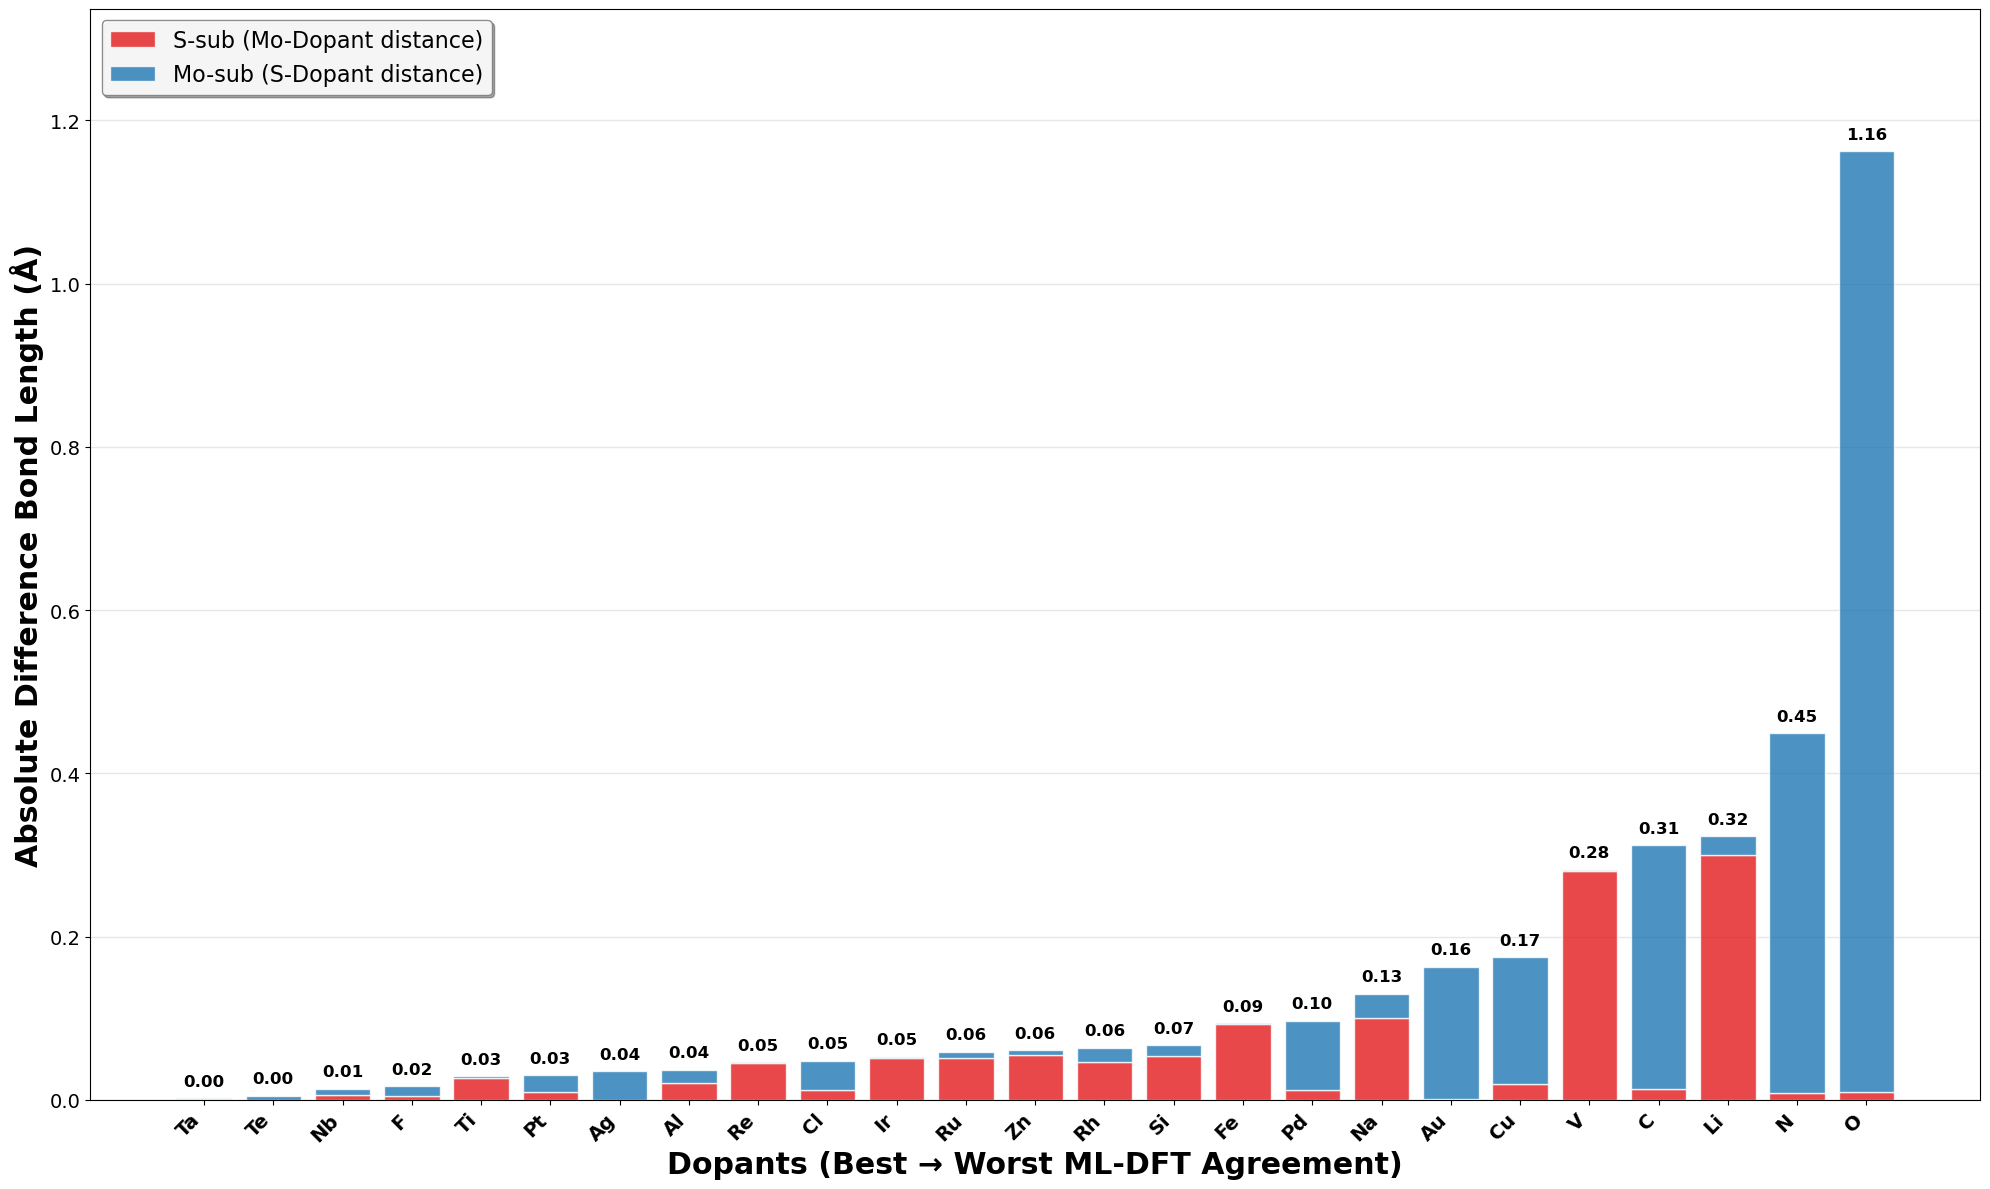

In [ ]:
import matplotlib.pyplot as plt

LABEL_FONT_SIZE = 18
TICK_LABEL_SIZE = 14
LEGEND_FONT_SIZE = 16
ANNOTATION_FONT_SIZE = 12
SAVEFIG_DPI = 200

def create_comparison_df_simple():
    """
    Create a comparison DataFrame between ML and DFT for S-Sub (Mo-Dopant) and Mo-Sub (S-Dopant) bond lengths.
    """
    print("🔄 Creating ML vs DFT comparison for S-Sub and Mo-Sub...")
    
    ml_df = mo_dopant_distances_df.copy()
    dft_df = bond_lengths_dft_df.copy()
    
    # Find common dopants
    common_dopants = set(ml_df['dopant_name']) & set(dft_df['dopant_name'])
    comparison_rows = []
    
    for dopant in sorted(common_dopants):
        ml_row = ml_df[ml_df['dopant_name'] == dopant].iloc[0]
        dft_row = dft_df[dft_df['dopant_name'] == dopant].iloc[0]
        
        for structure_type, ml_col, dft_col in [
            ('S_substitution', 'S_sub', 'S_sub'),
            ('Mo_substitution', 'Mo_sub', 'Mo_sub')
        ]:
            ml_val = ml_row[ml_col] if pd.notna(ml_row[ml_col]) else None
            dft_val = dft_row[dft_col] if pd.notna(dft_row[dft_col]) else None
            
            comparison_row = {
                'dopant': dopant,
                'structure_type': structure_type,
                'ml_distance': ml_val,
                'dft_distance': dft_val,
            }
            
            if ml_val is not None and dft_val is not None:
                distance_diff = ml_val - dft_val
                abs_distance_diff = abs(distance_diff)
                comparison_row.update({
                    'distance_diff': distance_diff,
                    'abs_distance_diff': abs_distance_diff,
                    'both_available': True
                })
            else:
                comparison_row.update({
                    'distance_diff': None,
                    'abs_distance_diff': None,
                    'both_available': False
                })
            comparison_rows.append(comparison_row)
    
    comparison_df = pd.DataFrame(comparison_rows)
    valid_df = comparison_df[comparison_df['both_available'] == True].copy()
    print(f"✅ Created comparison DataFrame for S-Sub and Mo-Sub.")
    return valid_df

def plot_bond_differences_simple(comparison_df):
    """
    Plot stacked bar chart for S-Sub (Mo-Dopant) and Mo-Sub (S-Dopant) bond length differences.
    """
    if comparison_df is None or len(comparison_df) == 0:
        print("❌ No valid comparison data to plot!")
        return None
    
    dopants = sorted(comparison_df['dopant'].unique())
    structure_types = ['S_substitution', 'Mo_substitution']
    plot_data = np.zeros((len(dopants), len(structure_types)))
    
    for i, dopant in enumerate(dopants):
        dopant_data = comparison_df[comparison_df['dopant'] == dopant]
        for j, struct_type in enumerate(structure_types):
            struct_data = dopant_data[dopant_data['structure_type'] == struct_type]
            if len(struct_data) > 0 and pd.notna(struct_data['abs_distance_diff'].iloc[0]):
                plot_data[i, j] = struct_data['abs_distance_diff'].iloc[0]
            else:
                plot_data[i, j] = 0
    
    total_errors = np.sum(plot_data, axis=1)
    sorted_indices = np.argsort(total_errors)
    plot_data = plot_data[sorted_indices]
    dopant_names = [dopants[i] for i in sorted_indices]
    total_errors = total_errors[sorted_indices]
    
    fig, ax = plt.subplots(figsize=(20, 12))
    colors = ['#E31A1C', '#1F78B4']
    formation_labels_short = ['S-sub (Mo-Dopant distance)', 'Mo-sub (S-Dopant distance)']
    x_positions = np.arange(len(dopant_names))
    bar_width = 0.8
    
    bars1 = ax.bar(x_positions, plot_data[:, 0], bar_width,
                   label=formation_labels_short[0], color=colors[0], alpha=0.8, 
                   edgecolor='white', linewidth=1)
    bars2 = ax.bar(x_positions, plot_data[:, 1], bar_width, 
                   bottom=plot_data[:, 0],
                   label=formation_labels_short[1], color=colors[1], alpha=0.8, 
                   edgecolor='white', linewidth=1)
    
    ax.set_xlabel('Dopants (Best → Worst ML-DFT Agreement)', fontsize=LABEL_FONT_SIZE*1.2, fontweight='bold')
    ax.set_ylabel('Absolute Difference Bond Length (Å)', fontsize=LABEL_FONT_SIZE*1.2, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(dopant_names, fontsize=TICK_LABEL_SIZE, fontweight='bold', rotation=45, ha='right')
    ax.legend(fontsize=LEGEND_FONT_SIZE, loc='upper left', frameon=True, fancybox=True,
              shadow=True, facecolor='white', edgecolor='gray', framealpha=0.9)
    ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)
    ax.tick_params(axis='x', labelsize=TICK_LABEL_SIZE)
    
    for i, (total_err, dopant) in enumerate(zip(total_errors, dopant_names)):
        if total_err > 0:
            ax.text(i, total_err + max(total_errors) * 0.01, f'{total_err:.2f}', 
                    ha='center', va='bottom', fontsize=ANNOTATION_FONT_SIZE, 
                    fontweight='bold', color='black')
    
    max_height = np.max(total_errors) if np.max(total_errors) > 0 else 1
    ax.set_ylim(0, max_height * 1.15)
    plt.tight_layout()
    os.makedirs("Analysis", exist_ok=True)
    output_file = "Analysis/ml_dft_bond_length_comparison_S_Mo_sub.png"
    plt.savefig(output_file, dpi=SAVEFIG_DPI, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"✓ Bond length comparison plot saved to: {output_file}")
    plt.show()
    return fig

# Main execution for S-Sub and Mo-Sub only
comparison_df_simple = create_comparison_df_simple()
if comparison_df_simple is not None:
    fig_simple = plot_bond_differences_simple(comparison_df_simple)
else:
    print("❌ Could not create comparison due to missing data.")


🔄 Creating ML vs DFT comparison for S-Sub and Mo-Sub...
✅ Created comparison DataFrame for S-Sub and Mo-Sub.
📊 Creating bond length difference plot (S-sub & Mo-sub) with standard formatting...
✓ Bond length comparison plot saved to: Analysis/ml_dft_bond_length_comparison_S_Mo_sub.png


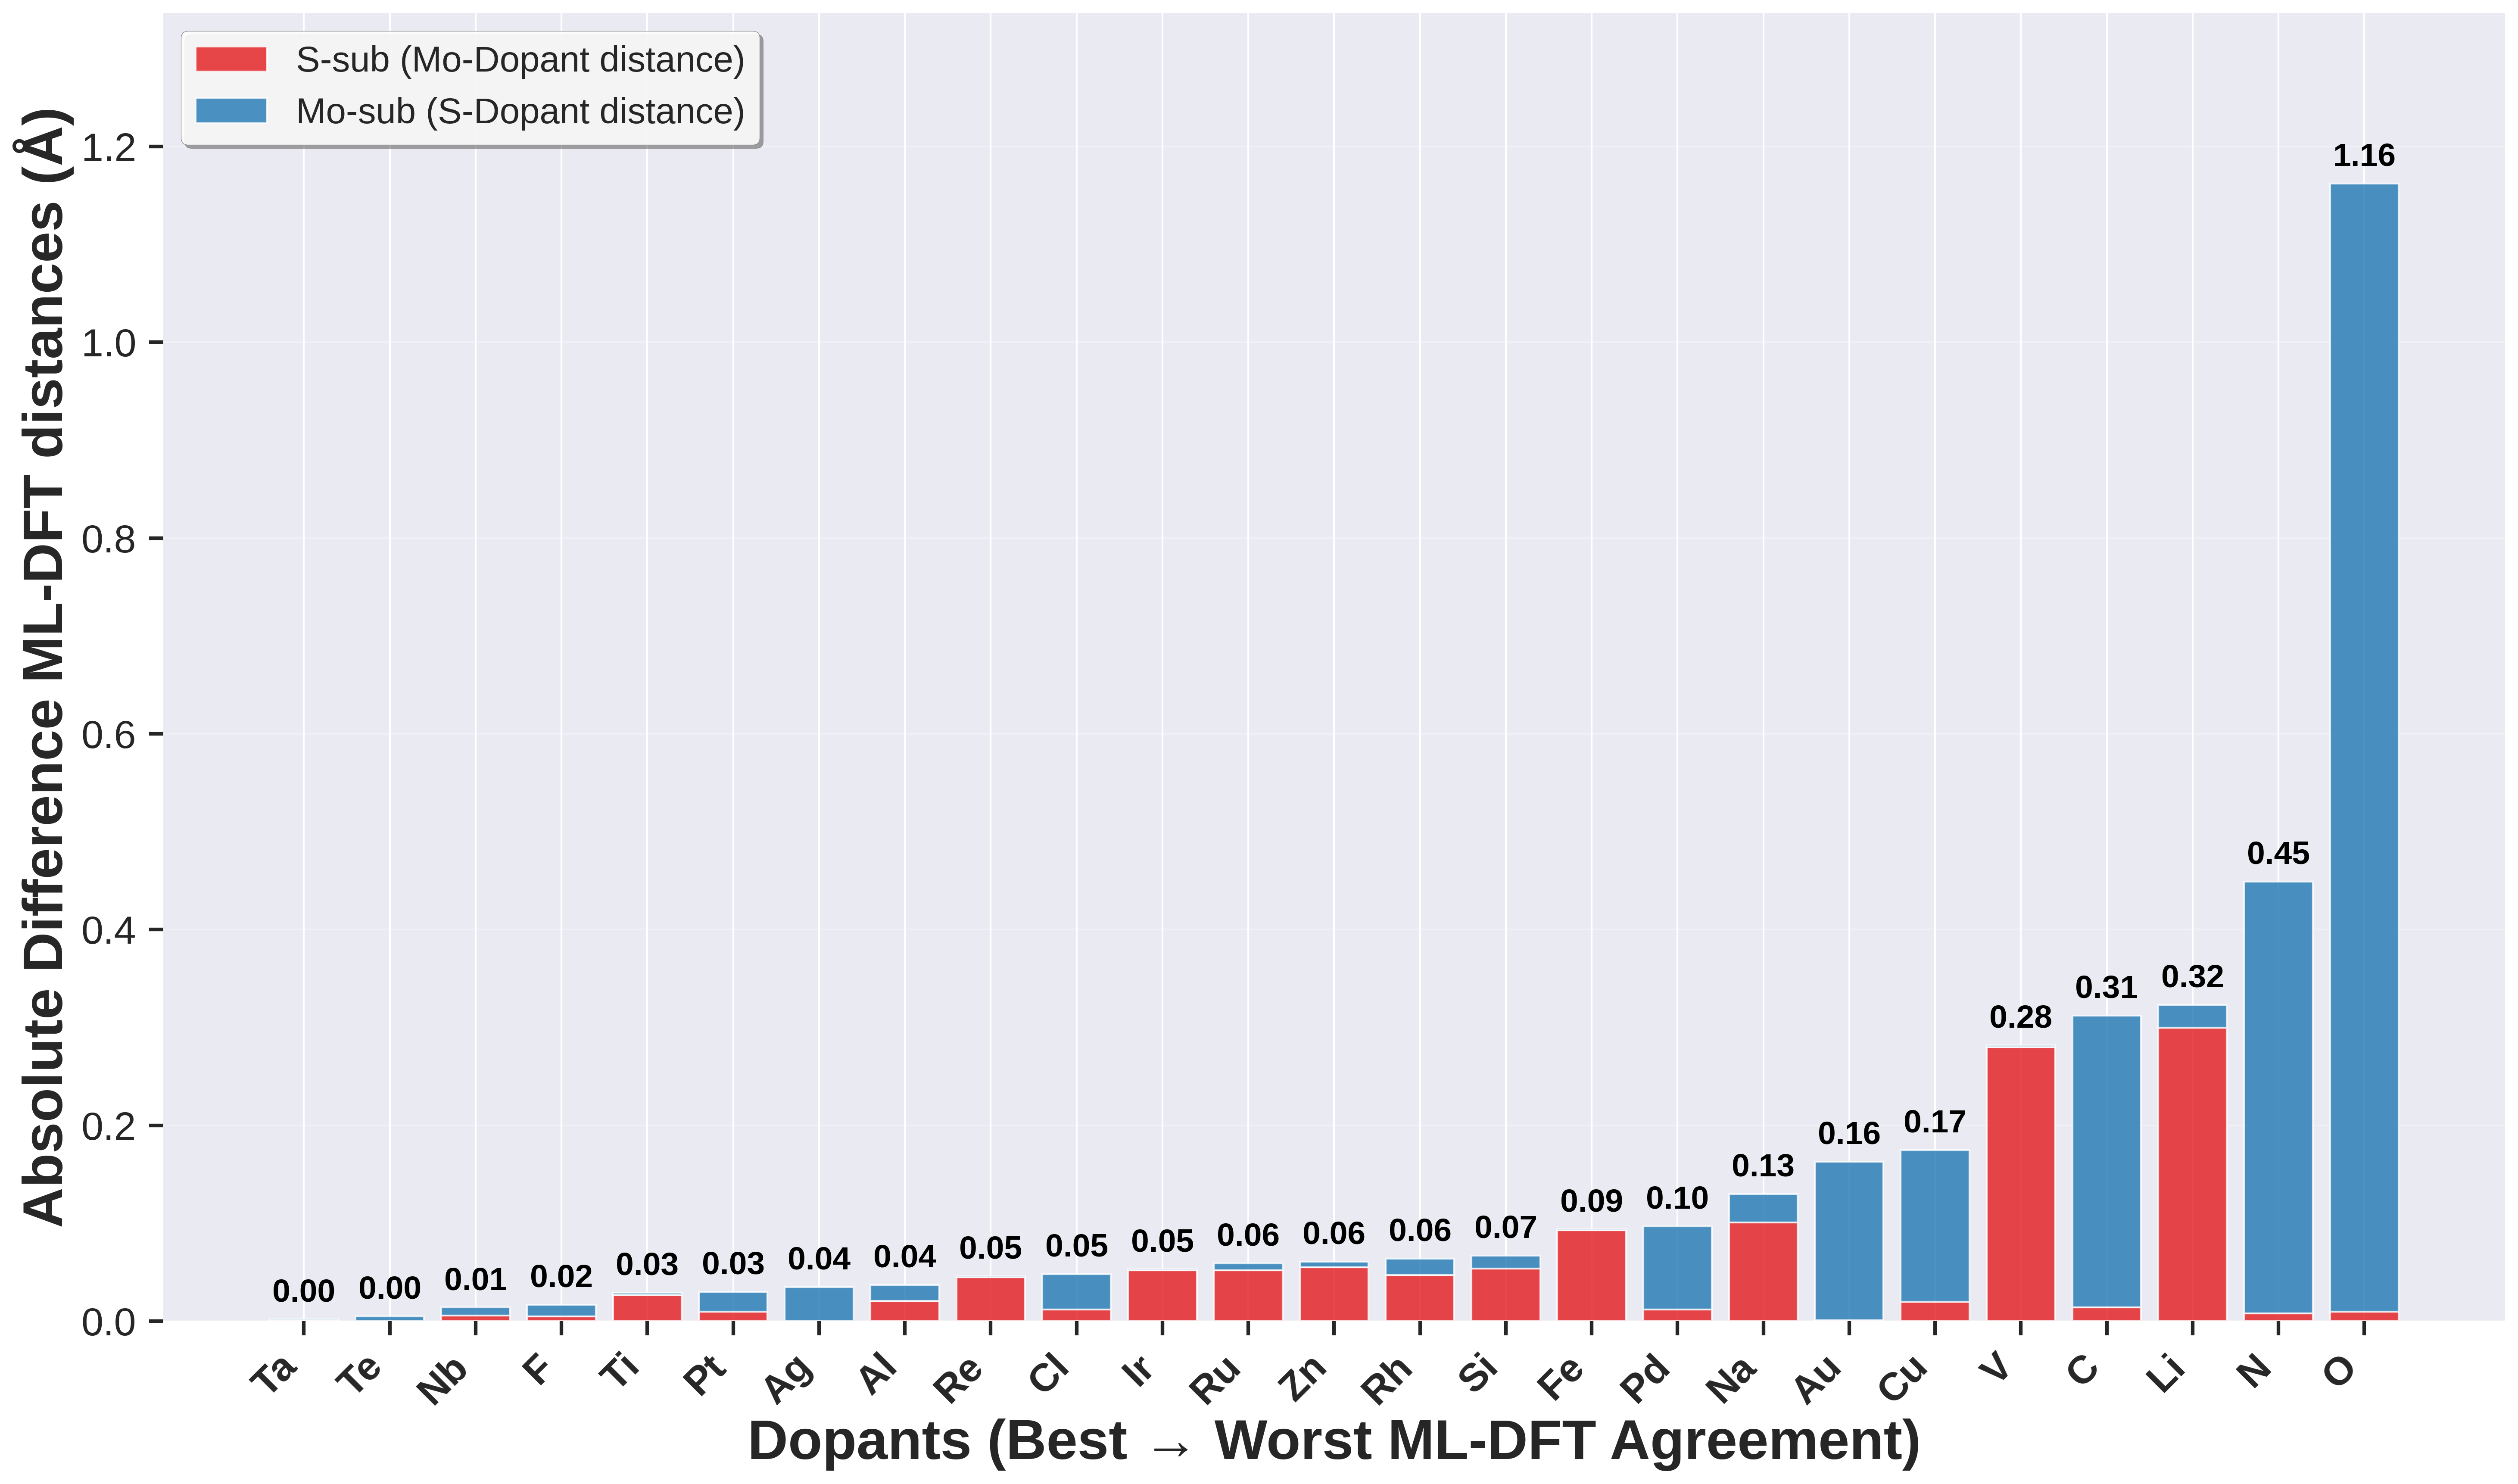

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# ---- Match EXACT formatting from the first plot script ----
plt.style.use('seaborn-v0_8')

FIGURE_DPI = 300
SAVEFIG_DPI = 600
FONT_SIZE = 24
TITLE_FONT_SIZE = 28
LABEL_FONT_SIZE = 26
TICK_LABEL_SIZE = 22
LEGEND_FONT_SIZE = 20
ANNOTATION_FONT_SIZE = 18
TICK_SIZE = 8
TICK_WIDTH = 2.0
MINOR_TICK_SIZE = 4
LINE_WIDTH = 3.0
MARKER_SIZE = 150

plt.rcParams.update({
    'figure.dpi': FIGURE_DPI,
    'savefig.dpi': SAVEFIG_DPI,
    'font.size': FONT_SIZE,
    'axes.titlesize': TITLE_FONT_SIZE,
    'axes.labelsize': LABEL_FONT_SIZE,
    'xtick.labelsize': TICK_LABEL_SIZE,
    'ytick.labelsize': TICK_LABEL_SIZE,
    'xtick.major.size': TICK_SIZE,
    'ytick.major.size': TICK_SIZE,
    'xtick.major.width': TICK_WIDTH,
    'ytick.major.width': TICK_WIDTH,
    'xtick.minor.size': MINOR_TICK_SIZE,
    'ytick.minor.size': MINOR_TICK_SIZE,
    'lines.linewidth': LINE_WIDTH,
    'legend.fontsize': LEGEND_FONT_SIZE,
    'savefig.facecolor': 'white'
})
# -----------------------------------------------------------

def create_comparison_df_simple():
    """
    Create a comparison DataFrame between ML and DFT for S-Sub (Mo-Dopant)
    and Mo-Sub (S-Dopant) bond lengths.
    """
    print("🔄 Creating ML vs DFT comparison for S-Sub and Mo-Sub...")

    ml_df = mo_dopant_distances_df.copy()
    dft_df = bond_lengths_dft_df.copy()

    # Find common dopants
    common_dopants = set(ml_df['dopant_name']) & set(dft_df['dopant_name'])
    comparison_rows = []

    for dopant in sorted(common_dopants):
        ml_row = ml_df[ml_df['dopant_name'] == dopant].iloc[0]
        dft_row = dft_df[dft_df['dopant_name'] == dopant].iloc[0]

        for structure_type, ml_col, dft_col in [
            ('S_substitution', 'S_sub', 'S_sub'),
            ('Mo_substitution', 'Mo_sub', 'Mo_sub')
        ]:
            ml_val = ml_row[ml_col] if pd.notna(ml_row[ml_col]) else None
            dft_val = dft_row[dft_col] if pd.notna(dft_row[dft_col]) else None

            comparison_row = {
                'dopant': dopant,
                'structure_type': structure_type,
                'ml_distance': ml_val,
                'dft_distance': dft_val,
            }

            if ml_val is not None and dft_val is not None:
                distance_diff = ml_val - dft_val
                abs_distance_diff = abs(distance_diff)
                comparison_row.update({
                    'distance_diff': distance_diff,
                    'abs_distance_diff': abs_distance_diff,
                    'both_available': True
                })
            else:
                comparison_row.update({
                    'distance_diff': None,
                    'abs_distance_diff': None,
                    'both_available': False
                })
            comparison_rows.append(comparison_row)

    comparison_df = pd.DataFrame(comparison_rows)
    valid_df = comparison_df[comparison_df['both_available'] == True].copy()
    print(f"✅ Created comparison DataFrame for S-Sub and Mo-Sub.")
    return valid_df

def plot_bond_differences_simple(comparison_df):
    """
    Plot stacked bar chart for S-Sub (Mo-Dopant) and Mo-Sub (S-Dopant) bond length differences,
    with EXACT formatting matching the first plot script.
    """
    if comparison_df is None or len(comparison_df) == 0:
        print("❌ No valid comparison data to plot!")
        return None

    print("📊 Creating bond length difference plot (S-sub & Mo-sub) with standard formatting...")

    # Prepare data
    dopants = sorted(comparison_df['dopant'].unique())
    structure_types = ['S_substitution', 'Mo_substitution']
    plot_data = np.zeros((len(dopants), len(structure_types)))

    for i, dopant in enumerate(dopants):
        dopant_data = comparison_df[comparison_df['dopant'] == dopant]
        for j, struct_type in enumerate(structure_types):
            struct_data = dopant_data[dopant_data['structure_type'] == struct_type]
            if len(struct_data) > 0 and pd.notna(struct_data['abs_distance_diff'].iloc[0]):
                plot_data[i, j] = struct_data['abs_distance_diff'].iloc[0]
            else:
                plot_data[i, j] = 0

    # Sort by total error
    total_errors = np.sum(plot_data, axis=1)
    sorted_indices = np.argsort(total_errors)
    plot_data = plot_data[sorted_indices]
    dopant_names = [dopants[i] for i in sorted_indices]
    total_errors = total_errors[sorted_indices]

    # Create the stacked bar plot
    fig, ax = plt.subplots(figsize=(20, 12))

    # Colors and labels (match first script)
    colors = ['#E31A1C', '#1F78B4']  # Red, Blue
    formation_labels_short = ['S-sub (Mo-Dopant distance)', 'Mo-sub (S-Dopant distance)']

    x_positions = np.arange(len(dopant_names))
    bar_width = 0.8

    ax.bar(
        x_positions, plot_data[:, 0], bar_width,
        label=formation_labels_short[0], color=colors[0], alpha=0.8,
        edgecolor='white', linewidth=1
    )

    ax.bar(
        x_positions, plot_data[:, 1], bar_width,
        bottom=plot_data[:, 0],
        label=formation_labels_short[1], color=colors[1], alpha=0.8,
        edgecolor='white', linewidth=1
    )

    # Labels and ticks (match first script)
    ax.set_xlabel('Dopants (Best → Worst ML-DFT Agreement)', fontsize=LABEL_FONT_SIZE*1.2, fontweight='bold')
    ax.set_ylabel('Absolute Difference ML-DFT Distances (Å)', fontsize=LABEL_FONT_SIZE*1.2, fontweight='bold')

    ax.set_xticks(x_positions)
    ax.set_xticklabels(dopant_names, fontsize=TICK_LABEL_SIZE, fontweight='bold', rotation=45, ha='right')

    # Legend styling
    ax.legend(fontsize=LEGEND_FONT_SIZE, loc='upper left', frameon=True, fancybox=True,
              shadow=True, facecolor='white', edgecolor='gray', framealpha=0.9)

    # Grid and axis settings
    ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    ax.tick_params(axis='y', labelsize=TICK_LABEL_SIZE)
    ax.tick_params(axis='x', labelsize=TICK_LABEL_SIZE)

    # Total error annotations
    for i, total_err in enumerate(total_errors):
        if total_err > 0:
            ax.text(
                i, total_err + max(total_errors) * 0.01, f'{total_err:.2f}',
                ha='center', va='bottom', fontsize=ANNOTATION_FONT_SIZE,
                fontweight='bold', color='black'
            )

    # Y-limits and layout
    max_height = np.max(total_errors) if np.max(total_errors) > 0 else 1
    ax.set_ylim(0, max_height * 1.15)
    plt.tight_layout()

    # Save
    os.makedirs("Analysis", exist_ok=True)
    output_file = "Analysis/ml_dft_bond_length_comparison_S_Mo_sub.png"
    plt.savefig(
        output_file, dpi=SAVEFIG_DPI, bbox_inches='tight',
        facecolor='white', edgecolor='none'
    )
    print(f"✓ Bond length comparison plot saved to: {output_file}")

    plt.show()
    return fig

# Main execution for S-Sub and Mo-Sub only
comparison_df_simple = create_comparison_df_simple()
if comparison_df_simple is not None:
    fig_simple = plot_bond_differences_simple(comparison_df_simple)
else:
    print("❌ Could not create comparison due to missing data.")
